# Validate Extraction

Compare demographic/ serology / clinical features to EAC! 

### #1.1 Import meta- & EAC data

In [1]:
import pandas as pd
metadata = pd.read_csv('../data/8_final/all_data_Mofa_clustering.csv')

# EAC data (selected on available PEC data & only if 1 y of follow-up is guaranteed)
df_eac = pd.read_csv(r'../data/5_validation/Merged_EAC.csv', sep='|', index_col=0)

# get date of first consult
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))
metadata['PEC'] = metadata['patnr'].apply(lambda x: new_pat[x]) # NEW PEC

In [ ]:
df_sub = metadata[metadata['patnr'].isin(df_eac['PATNR'])]
df_sub2 = df_eac[df_eac['PATNR'].isin(metadata['patnr'])].drop_duplicates(['PATNR'])
df_complete = df_sub.merge(df_sub2,left_on='patnr', right_on='PATNR')
df_complete['CCP2val_boolean'] = (df_complete['CCP2val_new'] > 9).astype(float) # larger than 9 implies that aCCP= True
df_complete.head()

### #1.2 Combine Metadata with Response data

In [ ]:
df_complete = df_complete[pd.DatetimeIndex(pd.to_datetime(df_complete['PEC'], format='%Y-%m-%d', errors='ignore')).tz_localize(None)>pd.to_datetime('2011-08-29', format='%Y-%m-%d', errors='ignore')]
df_response = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/SummaryResponseTable.csv', sep=';')
df_complete = df_complete.merge(df_response,left_on='patnr', right_on='patnr')
df_complete

## #2 Evaluate HIX extraction

### #2.1 Assess similarity between RF, ESR and aCCP 

In [14]:
d_link = {'RF' : 'rf_neg_pos', 'BSE' : 'bse', 'aCCP' : 'CCP2val_boolean'}
for feat in d_link.keys():
    # get equivalent of feature
    eq_feat = d_link[feat]
    pos = len(df_complete[(df_complete[eq_feat]==df_complete[feat]) & (~df_complete[eq_feat].isna()) & (df_complete[feat]!=2)][[eq_feat, feat]])
    tot = pos  + len(df_complete[(df_complete[eq_feat]!=df_complete[feat]) & (~df_complete[eq_feat].isna()) & (df_complete[feat]!=2)][[eq_feat, feat]])
    print('%s: %.3f' % (feat, pos/tot))

RF: 0.922
BSE: 0.806
aCCP: 0.926


### #2.2 Create histogram to visualize difference between DAT1EBEZ (EAC) and PEC (HIX)

Text(0.5, 0, 'Delta days between DAT1EBEZ (EAC) and PEC (HIX)')

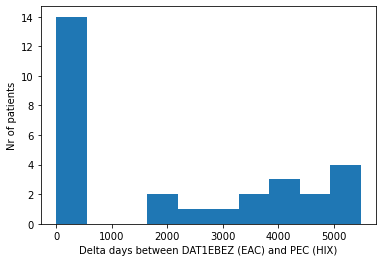

In [31]:
import matplotlib.pyplot as plt

l_val = list([i for i in (df_complete[(df_complete[eq_feat]!=df_complete[feat]) & (~df_complete[eq_feat].isna()) & (df_complete[feat]!=2)]['DeltaFirstDate']) if i == i])

plt.figure()
plt.hist(l_val)
plt.ylabel('Nr of patients')
plt.xlabel('Delta days between DAT1EBEZ (EAC) and PEC (HIX)')


### #2.3 Print out all patients with a disconcordant aCCP (EAC vs HIX)

In [ ]:
df_complete[(df_complete[eq_feat]!=df_complete[feat]) & (~df_complete[eq_feat].isna()) & (df_complete[feat]!=2)][[eq_feat, feat, 'DeltaFirstDate']]

### #2.4 Evaluate DAS44 similarity (EAC vs HIX) - with a tolerance of 0.5

In [ ]:
df_complete['DeltaDAS'] = abs(df_complete[eq_feat] - df_complete[feat])

tolerance = 0.5
pos = len(df_complete[(~df_complete['DAS44'].isna()) & (~df_complete['rn1_DAS44'].isna()) & (df_complete['DeltaDAS']<=tolerance)][['DeltaDAS', 'DAS44', 'rn1_DAS44']])
tot = pos + len(df_complete[(~df_complete['DAS44'].isna()) & (~df_complete['rn1_DAS44'].isna()) & (df_complete['DeltaDAS']>tolerance)][['DeltaDAS', 'DAS44', 'rn1_DAS44']])
print('Baseline DAS44 accuracy (tol=%.2f DAS): %.3f' % (tolerance, pos/tot))


#### Plot absolute differences in DAS44

Text(0, 0.5, 'Delta DAS44')

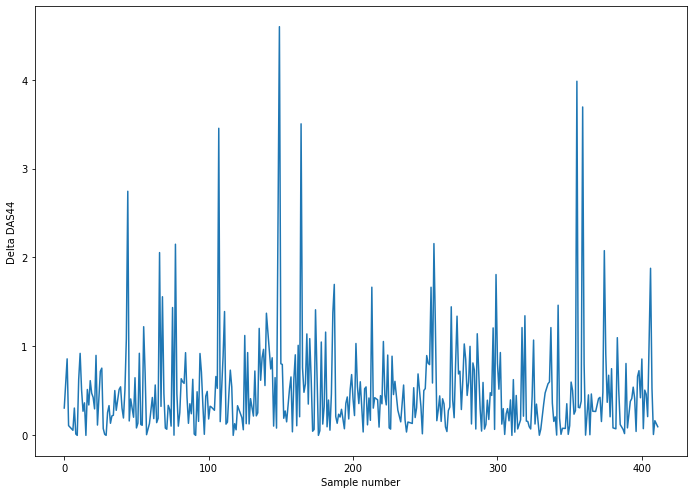

In [91]:
df_complete[(df_complete[eq_feat]!=df_complete[feat]) & (~df_complete[eq_feat].isna())][[eq_feat, feat]]
a4_dims = (11.7, 8.27)
#fig = plt.plot(figsize=a4_dims)
lines = abs(df_complete[(~df_complete[feat].isna()) & (~df_complete[eq_feat].isna())][feat]-df_complete[(~df_complete[feat].isna()) & (~df_complete[eq_feat].isna())][eq_feat]).plot.line(figsize=a4_dims)
lines.set_xlabel('Sample number')
lines.set_ylabel('Delta DAS44')

### #2.5 Compare first dates between EAC (DAT1EBEZ) and HIX (PEC)
We took a tolerance of 31 days

In [4]:

d1 = pd.DatetimeIndex(pd.to_datetime(df_complete['DAT1EBEZ'], format='%Y-%m-%d', errors='ignore'))#.tz_convert(None)
d2 = pd.DatetimeIndex(pd.to_datetime(df_complete['PEC'], format='%Y-%m-%d', errors='ignore')).tz_convert(None)

df_complete['DeltaFirstDate'] = abs(d1 - d2).days
df_complete[['DAT1EBEZ', 'PEC', 'DeltaFirstDate']]

tolerance = 31
pos = len(df_complete[df_complete['DeltaFirstDate']<=tolerance][['DAT1EBEZ', 'PEC', 'DeltaFirstDate']])
tot = pos + len(df_complete[df_complete['DeltaFirstDate']>tolerance][['DAT1EBEZ', 'PEC', 'DeltaFirstDate']])
print('First date accuracy (tol=%i days): %.3f' % (tolerance, pos/tot))


First date accuracy (tol=31 days): 0.827


Text(0.5, 0, 'Delta days between DAT1EBEZ (EAC) and PEC (HIX)')

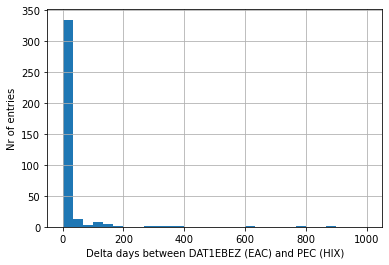

In [55]:
plt = df_complete['DeltaFirstDate'].hist(bins=30, range=(0, 1000))
plt.set_ylabel('Nr of entries')
plt.set_xlabel('Delta days between DAT1EBEZ (EAC) and PEC (HIX)')

In [43]:
len(df_complete[df_complete['DeltaFirstDate']>62][['DAT1EBEZ', 'PEC', 'DeltaFirstDate']])

59